### Notes from meeting with Steve 11/19
- spatial analysis component
- show time of fracking events
- Have time to create video since it's time consuming


- Cluster on magnitude?

### Notes from meeting with Steve 12/04
- Explain what *moments* are and include units
- Retain zooming options in Tableau from earthquakes to wells OR add wells as layer to earthquake data
- Injection time data? So far, we have not found dates but there are reports dated as early as 2011
    - The reports that are dated don't contain the locations
- Kriging: https://en.wikipedia.org/wiki/Kriging
- He'll get back to us about finding a good model for continuous data
- Look at past homeworks and follow a similar outline for project


- I suggest to add the regression model

# Experimenting with data :)
*By Kamrine Poels*

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import itertools as it

In [3]:
##### IMPORT THE DATA FRAME FROM 2015
#import json
#with open("tempdata/df.json") as json_file:
#     df = json.load(json_file)
#df = pd.read_json(df)

In [4]:
#initialize the dataframe with 1980 data
eq_df = pd.read_csv('tempdata/earthquakes_catalog.csv')
print eq_df.shape
eq_df.head()

,id,origintime,latitude,longitude,depth,err_lon,err_lat,err_depth,err_origintime,county,origin_src,prefmag,pmag_type,pmag_src,mw,mw_src,mblg_ogs,mblg_usgs,ml_ogs,m3hz_ogs,md_ogs,mb,ms,mfa,max_mmi,reafile,reamtime,geom,pdlid,mw_ogs
0,255,1980-01-05 07:11:31.21,35.586,-97.894,5,NaN,NaN,NaN,NaN,CANADIAN,OGS,1.9,M3Hz,OGS,NaN,NaN,1.6,NaN,NaN,1.9,1.7,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E6100000F0A7C64B377958C05EBA490C02CB...,NaN,NaN
1,256,1980-01-12 07:12:56.45,36.453,-97.642,5,NaN,NaN,NaN,NaN,GARFIELD,OGS,1.7,M3Hz,OGS,NaN,NaN,NaN,NaN,NaN,1.7,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000000C022B87166958C0448B6CE7FB39...,NaN,NaN
2,257,1980-02-03 00:46:30.05,33.994,-97.463,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.2,M3Hz,OGS,NaN,NaN,1.9,NaN,NaN,2.2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000001283C0CAA15D58C0AC1C5A643BFF...,NaN,NaN
3,258,1980-02-05 04:32:35.45,34.046,-97.451,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.1,M3Hz,OGS,NaN,NaN,2.3,NaN,NaN,2.1,1.9,NaN,NaN,NaN,3,NaN,NaN,0101000020E6100000BE9F1A2FDD5C58C0D9CEF753E305...,NaN,NaN
4,259,1980-03-09 03:57:10.56,35.100,-95.100,5,NaN,NaN,NaN,NaN,HASKELL,OGS,1.2,M3Hz,OGS,NaN,NaN,1.4,NaN,NaN,1.2,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000006666666666C657C0CDCCCCCCCC8C...,NaN,NaN


## Visualizations of earthquake data since 1980

Magnitude seems to remain unaffected despite larger number of detected earthquakes. If most if not all seismometers were present in OK since ~1960, then there is an obvious increase in earthquakes starting in 2010, a year after fracking. 

See http://earthquake.usgs.gov/earthquakes/eqinthenews/2011/usb0006klz/ for largest earthquake in OK

## Quick look at all combined data

In [13]:
all_df = pd.read_csv('http://wichita.ogs.ou.edu/eq/catalog/complete/complete.csv')

In [14]:
# Extract time of each earthquake
year = []
for date in all_df.origintime.values:
    new_date = time.strptime(date[:19], "%Y-%m-%d %H:%M:%S")
    year.append(new_date.tm_year)    
all_df['year'] = year
# Group by year
all_df_byYear = all_df.groupby('year')

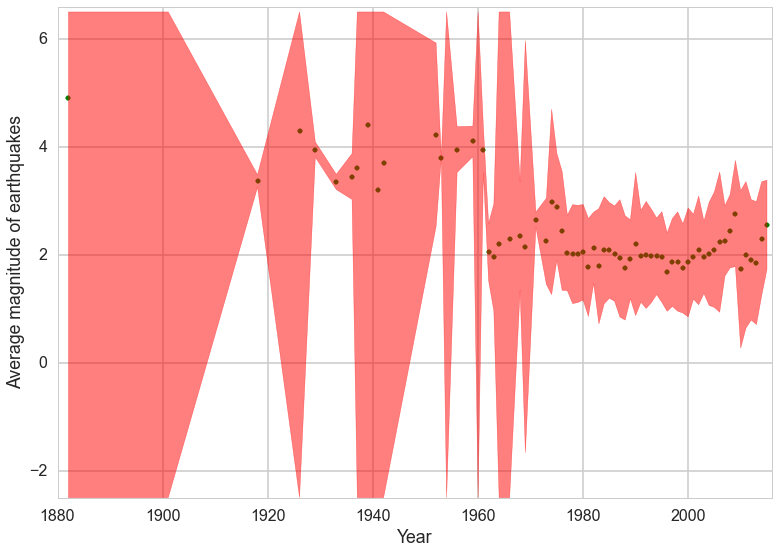

In [15]:
low = []
up = []
for mean, std in zip(all_df_byYear.prefmag.mean(), all_df_byYear.prefmag.std()):
    if std != std:
        low.append(-2.5)
        up.append(6.5)
    else:
        low.append(mean-2*std)
        up.append(mean+2*std)
plt.scatter(sorted(all_df_byYear.groups.keys()), all_df_byYear.prefmag.mean(), color = 'g')
plt.fill_between(sorted(all_df_byYear.groups.keys()), low, up, color = 'r', alpha = .5)
plt.xlim(1880, 2016)
plt.ylim(-2.5,6.6)
plt.xlabel("Year")
plt.ylabel("Average magnitude of earthquakes")

Ew, this looks ugly. It's best we work with data since 1980...

# Download *Water disposal wells* data

Data taken from http://www.occeweb.com/og/ogdatafiles2.htm.

## Water disposal wells: predicted inducer of earthquakes

In [23]:
#wellvol = pd.read_csv('tempdata/wells_reportyear.csv')
#wellvol = wellvol[np.isfinite(wellvol['YEAR'])]
#welldf = wellvol[(wellvol.LONGITUDE >= -102.918) & (wellvol.LONGITUDE <= -94.466)]
#welldf = welldf[(welldf.LATITUDE >= 33.811) & (welldf.LATITUDE <= 36.99869)]
#welldf = welldf[welldf.YEAR <= 2015]
#print welldf.shape
#welldf.head()
# Save cleaned dataframe:
# welldf.to_csv('tempdata/wells_data.csv')
# Read clean data frame
welldf = pd.read_csv('tempdata/wells_data.csv')
print welldf.shape
welldf.head()

(53389, 10)


,API_COUNTY,API_NUMBER,LEASE_NAME,WELL_NUMBER,LATITUDE,LONGITUDE,YEAR,FLUID_TYPE,PACKERDPTH,VOLUME
0,3,26,SE EUREKA UNIT-TUCKER #1,21,36.900324,-98.21826,2007,S,4850,9540
1,3,26,SE EUREKA UNIT-TUCKER #1,21,36.900324,-98.21826,2008,S,4850,12236
2,3,26,SE EUREKA UNIT-TUCKER #1,21,36.900324,-98.21826,2009,S,4850,11825
3,3,26,SE EUREKA UNIT-TUCKER #1,21,36.900324,-98.21826,2010,S,4850,11863
4,3,163,CHRISTENSEN,1,36.896636,-98.17772,2006,S,4933,34783


# Linear Regression

We break the area into subregions, count the number of earthquakes and number of disposal wells. Perform linear regression.

In [26]:
## For looking at other grid sizes, start loop here
# Make ranges
xregions1 = np.arange(33.5, 37., 0.1)
xregions2 = np.arange(34., 37.5, 0.1) 
xregions = zip(xregions1, xregions2)
yregions1 = np.arange(-103.,-94. , 0.1) 
yregions2 = np.arange(-102.5 ,-93.5, 0.1)
yregions = zip(yregions1, yregions2)

# Create a dictionary with keys = (slice in long, slice in latitude)
# value = number of the grid cell
regions = it.product(xregions,yregions)
locdict = dict(zip(regions, range(len(xregions)*len(yregions))))

print 'total number of region', len(locdict.keys())

# Make two data frames for post and prior to 2010
reg_df_prior = pd.DataFrame(index = range(len(locdict.keys()))\
			, columns = ['quakes', 'wells', 'volume'])
reg_df_prior.index.name = 'region'

reg_df_post = pd.DataFrame(index = range(len(locdict.keys()))\
			, columns = ['quakes', 'wells', 'volume'])
reg_df_post.index.name = 'region'

def mask_region(df, region):
	mask_region = (df['latitude'] < region[0][1]) \
	        & (df['latitude'] >= region[0][0]) \
	        & (df['longitude'] < region[1][1]) \
	        & (df['longitude'] >= region[1][0])
	return mask_region

# Filter by time 
eq_df_prior = eq_df[eq_df.year < 2010]
welldf_prior = welldf[welldf.year < 2010]
eq_df_post = eq_df[eq_df.year >= 2010]
welldf_post = welldf[welldf.year >= 2010]

### Start grid size loop here
for region in locdict.keys():
	# just do one print to see what is hapenning
	if locdict[region] == 23:
		print 'region number', locdict[region]
		print 'number of quakes in this region'\
			,eq_df[mask_region(eq_df,region)].count().values[0]
		print 'number of wells in this region'\
			,welldf[mask_region(welldf,region)].count().values[0]	
		print 'total volume injected in this region'\
			,welldf[mask_region(welldf,region)].volume.sum()			
	reg_df_prior.loc[(locdict[region]),'quakes']= eq_df_prior[mask_region(eq_df_prior,region)].count().values[0]
	reg_df_prior.loc[(locdict[region]),'wells']= welldf_prior[mask_region(welldf_prior,region)].count().values[0]
	reg_df_prior.loc[(locdict[region]),'volume'] = welldf_prior[mask_region(welldf_prior,region)].volume.sum()
	reg_df_post.loc[(locdict[region]),'quakes']= eq_df_post[mask_region(eq_df_post,region)].count().values[0]
	reg_df_post.loc[(locdict[region]),'wells']= welldf_post[mask_region(welldf_post,region)].count().values[0]
	reg_df_post.loc[(locdict[region]),'volume'] = welldf_post[mask_region(welldf_post,region)].volume.sum()

total number of region 3150
region number 23
number of quakes in this region 0
number of wells in this region 0
total volume injected in this region 0


### Prior 2010

In [27]:
quakes = []; wells = []; volume = []
for row in range(reg_df_prior.shape[0]):
    quakes.append(int(reg_df_prior.loc[row, 'quakes']))
    wells.append(int(reg_df_prior.loc[row, 'wells']))
    volume.append(int(reg_df_prior.loc[row, 'volume']))
simp_reg_prior = {'quakes':quakes, 'wells':wells, 'volume':volume}
simp_reg_prior = pd.DataFrame(simp_reg_prior)
olsQuakes_prior = sm.ols(formula = 'quakes ~ wells+volume', data = simp_reg_prior).fit()
print olsQuakes_prior.summary()

                            OLS Regression Results                            
Dep. Variable:                 quakes   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     475.1
Date:                Tue, 08 Dec 2015   Prob (F-statistic):          4.81e-181
Time:                        12:50:35   Log-Likelihood:                -5304.8
No. Observations:                3150   AIC:                         1.062e+04
Df Residuals:                    3147   BIC:                         1.063e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2857      0.025     11.603      0.0

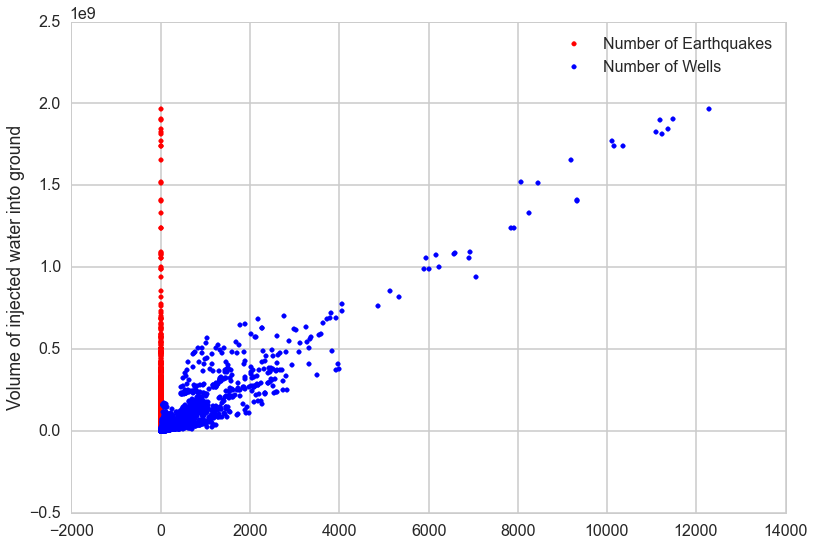

In [28]:
plt.scatter(simp_reg_prior.quakes, simp_reg_prior.volume, label = 'Number of Earthquakes', color = 'r')
plt.scatter(simp_reg_prior.wells, simp_reg_prior.volume, label = 'Number of Wells', color = 'b')
plt.ylabel('Volume of injected water into ground')
plt.legend()

### Post 2010

In [29]:
quakes = []; wells = []; volume = []
for row in range(reg_df_post.shape[0]):
    quakes.append(int(reg_df_post.loc[row, 'quakes']))
    wells.append(int(reg_df_post.loc[row, 'wells']))
    volume.append(int(reg_df_post.loc[row, 'volume']))
simp_reg_post = {'quakes':quakes, 'wells':wells, 'volume':volume}
simp_reg_post = pd.DataFrame(simp_reg_post)
olsQuakes_post = sm.ols(formula = 'quakes ~ wells+volume', data = simp_reg_post).fit()
print olsQuakes_prior.summary()

                            OLS Regression Results                            
Dep. Variable:                 quakes   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     475.1
Date:                Tue, 08 Dec 2015   Prob (F-statistic):          4.81e-181
Time:                        12:50:36   Log-Likelihood:                -5304.8
No. Observations:                3150   AIC:                         1.062e+04
Df Residuals:                    3147   BIC:                         1.063e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2857      0.025     11.603      0.0

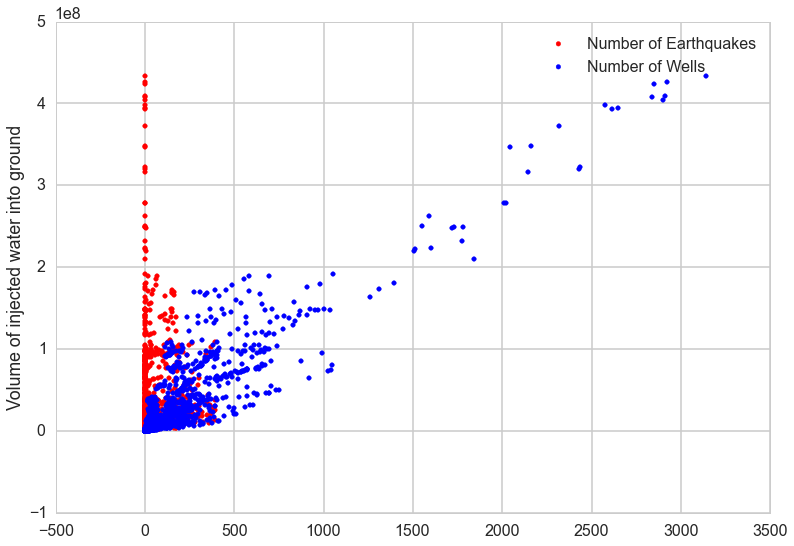

In [30]:
plt.scatter(simp_reg_post.quakes, simp_reg_post.volume, label = 'Number of Earthquakes', color = 'r')
plt.scatter(simp_reg_post.wells, simp_reg_post.volume, label = 'Number of Wells', color = 'b')
plt.ylabel('Volume of injected water into ground')
plt.legend()

In [ ]:
### End grid size loop here

## T-test and permutation test

In [58]:
# 
eq_df_priorByYear = eq_df_prior.groupby('year').count().reset_index().prefmag
eq_df_postByYear = eq_df_post.groupby('year').count().reset_index().prefmag
t_test = sp.stats.ttest_ind(eq_df_priorByYear, eq_df_postByYear, equal_var=False)

In [59]:
t_test


(-2.0457344281742, 0.096159702214862808)

0     41
1    112
2     38
3    109
4    584
5    842
Name: prefmag, dtype: int64